In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
import analyze_utils

save_dir = '/home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels_rerun'

r = analyze_utils.load_results_and_cache_autoprompt_json(save_dir, save_file='r.pkl')

calling


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 70.92it/s]


In [5]:
top_prompts = (
    r.groupby(['task_name', 'seed', 'max_digit'])
).first().reset_index()
top_prompts[['task_name', 'seed', 'max_digit', 'prefixes', 'reciprocal_rank']]

,task_name,seed,max_digit,prefixes,reciprocal_rank
0,add_two,1,10,"Write a function called ""sum",1.000000
1,add_two,1,40,Your name plus an integer?,0.111111
2,add_two,1,80,_Input three_ `-,0.200000
3,add_two,1,160,Your name plus an integer?,0.166667
4,add_two,2,10,Write a function to add pairs,1.000000
...,...,...,...,...,...
67,subtract_two,2,40,"""Write a function that takes",0.017544
68,subtract_two,2,80,"Given a number, find its",0.100000
69,subtract_two,2,160,Given some int values m1,0.142857
70,subtract_two,3,10,Given an array of positive,0.018519


In [8]:
top_prompts['reciprocal_rank'].mean()

0.12581689764458714

<AxesSubplot:ylabel='max_digit'>

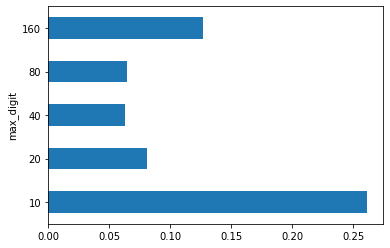

In [7]:
top_prompts.groupby('max_digit').mean()['reciprocal_rank'].plot(kind='barh')

In [4]:
assert r['checkpoint'].unique()[0] == "EleutherAI/gpt-j-6B"

In [5]:
from iprompt import prompt_classification

model = prompt_classification.create_model(r['checkpoint'].unique()[0])

2023-01-17 15:40:20.579743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 15:40:20.761782: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-17 15:40:20.798810: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-17 15:40:21.879204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [6]:
## Compute accuracy given correct prompt and save for each task.
import argparse
from tqdm.notebook import tqdm
from iprompt.data import get_data


data = []
print('calculating accs...')
n_shots = 1
batch_size = 16

"""
task_name: str = 'add_two',
 n_shots: int = 1,
 train_split_frac: float = None,
 max_dset_size: int = 10000,
 template_num_task_phrasing: int = 0,
 max_digit: int = 10,
 """

for _, output in tqdm(top_prompts.iterrows(), total=len(top_prompts)):
    args = argparse.Namespace(**output)
    (dset, dset_test), check_answer_func, descr = get_data(
        args.task_name, n_shots=n_shots, train_split_frac=args.train_split_frac,
        max_dset_size=args.max_dset_size, template_num_task_phrasing=0,
        max_digit=args.max_digit,
    )
    # if task_name == 'task107_splash_question_to_sql':
    #     batch_size = max(1, batch_size//4)
    ####   Manual prompt  ####
    manual_loss, manual_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=descr, multi_token=False, verbose=False,
        batch_size=batch_size,
    )
    ####   iPrompt prompt   ####
    iprompt_loss, iprompt_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=output['prefixes'], multi_token=False, verbose=False,
        batch_size=batch_size,
    )
    ####
    output['manual_acc'] = manual_acc
    output['iprompt_acc'] = iprompt_acc
    data.append(output)

calculating accs...


  0%|          | 0/150 [00:00<?, ?it/s]

In [21]:
output['prefixes']

' Given n positive integers that add'

In [8]:
import os

top_prompts_df = pd.DataFrame(data)
top_prompts_df.to_pickle(os.path.join(save_dir, 'top_prompts.pkl'))

In [18]:
top_prompts_df['prompt_ratio'] = top_prompts_df['manual_acc'] / top_prompts_df['iprompt_acc']

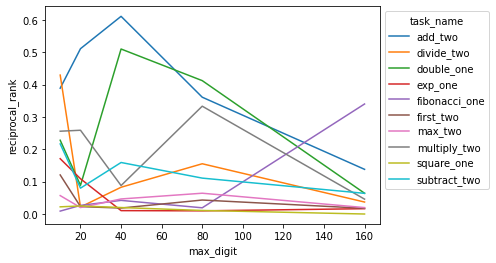

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

r_grouped_by_task = (
    top_prompts_df
     .groupby(['max_digit', 'task_name']).mean()
     .reset_index()
)

ax = sns.lineplot(
    data=r_grouped_by_task, x='max_digit', y='reciprocal_rank', hue='task_name',
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # legend outside of plot
# ax.set_yscale('log')

In [38]:
top_prompts_df[top_prompts_df['reciprocal_rank'] < 0.1][['prefixes','reciprocal_rank','task_name']]

,prefixes,reciprocal_rank,task_name
0,Input two positive integer values,0.066667,add_two
9,Input three natural-number pairs,0.071429,add_two
16,"1 /, 2 %",0.011905,divide_two
17,Input two integers m (the,0.024390,divide_two
19,Given a fraction F (a,0.037037,divide_two
...,...,...,...
144,"Given 3 digits x, y",0.083333,subtract_two
145,Write a function named sum,0.066667,subtract_two
146,1 Given 2 Prompt 3 <,0.045455,subtract_two
148,"Given 3 positive integers a,",0.030303,subtract_two
